In [2]:
from generate_dataset import generate_ds
generate_ds("train_2_1000.csv",2,1000)

In [1]:
import torch
from torch import optim, nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms as T
from torchvision import models, datasets
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from time import sleep

from utils import imshow, show_batch, show_image, show_image_pair
from models import ContrastiveLoss, EfficientSiemens, SiameseNetworkSimple
from generate_dataset import SiameseDataset

/Users/kristinanikolic/opt/anaconda3/envs/CV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define main data directory
DATA_DIR = 'tiny-imagenet-200-test' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [3]:
# Define device to use (CPU or GPU). CUDA = GPU support for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using: " + str(device))

Using: cpu


In [4]:
# Define transformation sequence for image pre-processing
# If not using pre-trained model, normalize with 0.5, 0.5, 0.5 (mean and SD)
# If using pre-trained ImageNet, normalize with mean=[0.485, 0.456, 0.406], 
# std=[0.229, 0.224, 0.225])

preprocess_transform_pretrain = T.Compose([
                T.Resize(224), # Resize images to 256 x 256
                #T.CenterCrop(224), # Center crop image
                #T.RandomHorizontalFlip(),
                T.ToTensor(),  # Converting cropped images to tensors
                T.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
])

simple = T.Compose([T.ToTensor(),  # Converting cropped images to tensors
])

In [5]:
train_data = SiameseDataset('train_2_1000.csv',TRAIN_DIR,preprocess_transform_pretrain)
batch_size = 128

if use_cuda:
    kwargs = {"pin_memory": True, "num_workers": 1}
else:
    kwargs = {}

# Wrap image dataset (defined above) in dataloader 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


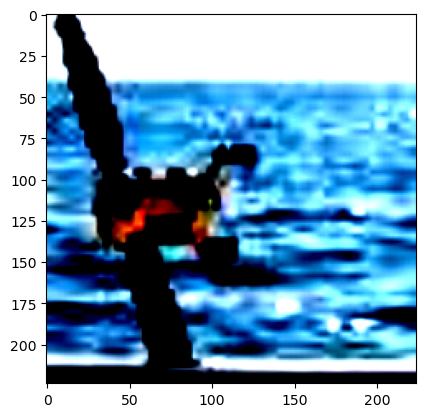

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


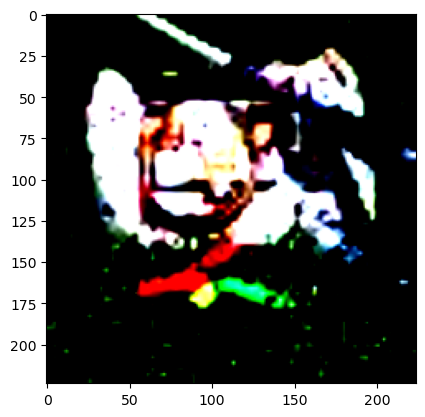

Label: tensor([1.]), Shape: torch.Size([3, 224, 224])


In [6]:
show_image_pair(train_dataloader)

In [7]:
# Declare Siamese Network
net = EfficientSiemens(4)
net = net.to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=False)
# Epochs
epochs = 50
tresholds = [0.5, 0.75, 1.0, 1.25, 1.5]
#train the model
def train():
    print(net)
    loss=[] 
    counter=[]
    acc = np.zeros(len(tresholds))
    for j in acc:
        j = []
    iteration_number = 0
    for epoch in range(1,epochs):
        acc_ep = np.zeros(len(tresholds))
        items = 0
        batch = 0
        for batch_id, smpl in enumerate(tqdm(train_dataloader)):
            sleep(0.1)
            img0, img1, label = smpl[0], smpl[1], smpl[2]
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
            for m in range(len(tresholds)):
                label_t = euclidean_distance<tresholds[m]
                acc_ep[m] = accuracy_score(label, label_t)*len(label) + acc_ep[m]
            items = items + len(label)
            batch = batch + 1
        print("Epoch {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
        for m in range(len(tresholds)):
            print("Current accuracy {} for {}\n".format(acc_ep[m]/items,tresholds[m]))
            acc[m].append(acc_ep[m]/items)
        iteration_number += 1
        counter.append(iteration_number)
        loss.append(loss_contrastive.item())
    plt.plot(counter, loss, label='Loss') 
    for m in range(len(tresholds)):
        plt.plot(counter, acc, label=str(treshold[m]))
    plt.legend()
    return net

5124


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully") 

EfficientSiemens(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

100%|██████████| 8/8 [01:06<00:00,  8.33s/it]

Epoch 1
 Current loss 0.5403690934181213

Current accuracy 0.5435435435435435 for 0.5



AttributeError: 'numpy.float64' object has no attribute 'append'